In [49]:
import os
import tensorflow as tf
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

## Global Variables

In [50]:
DIR_DATA = 'data_small'
DIR_INPUT = os.path.join(DIR_DATA, 'input')
DIR_OUTPUT = os.path.join(DIR_DATA, 'output')
OBJECT_LABELS = {
    'none': (0, 'Background'),
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle'),
    'tvmonitor': (20, 'Indoor'),
}
NUM_OBJECTS = 20
DIM_OUTPUT_PER_GRID_PER_ANCHOR = 5 + NUM_OBJECTS

# Reference: https://github.com/pjreddie/darknet/blob/master/cfg/yolo-voc.cfg#L242
ANCHORS = np.array(
    [
        [1.73145, 1.3221],
        [4.00944, 3.19275],
        [8.09892, 5.05587],
        [4.84053, 9.47112],
        [10.0071, 11.2364]
    ]
)

GRID_SIZE = 32
GRID_H, GRID_W = 19, 19
IMG_OUT_H, IMG_OUT_W = GRID_H * GRID_SIZE, GRID_W * GRID_SIZE 

DIR_TFRECORDS = 'data_small_tfrecords'
NUM_EXAMPLES_PER_TFRECORD = 10

## Process data

In [55]:
def read_data(filename):
    # Reference: This function has been modified from 
    # https://github.com/balancap/SSD-Tensorflow/blob/master/datasets/pascalvoc_to_tfrecords.py
    
    # read and process image
    img_name = os.path.join(DIR_INPUT, filename + '.jpg')
    img = cv2.imread(img_name)
    img_in_h = img.shape[0]
    img_in_w = img.shape[1]
    img = cv2.resize(img, (IMG_OUT_W, IMG_OUT_H))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = (img / 255.0) * 2.0 - 1.0  # normalize
    
    # read annotation
    annotation_name = os.path.join(DIR_OUTPUT, filename + '.xml')
    tree = ET.parse(annotation_name)
    root = tree.getroot()
    targets = []
    for obj in root.findall('object'):
        # read class label
        label_text = obj.find('name').text
        label = int(OBJECT_LABELS[label_text][0])
        
        # read bbox
        bbox = obj.find('bndbox')
        y_min = float(bbox.find('ymin').text)
        x_min = float(bbox.find('xmin').text)
        y_max = float(bbox.find('ymax').text)
        x_max = float(bbox.find('xmax').text)
        
        # convert to x_center, y_center, width, height
        y_center, x_center = (y_min + y_max)/2., (x_min + x_max)/2.
        bbox_h, bbox_w = y_max - y_min, x_max - x_min
        
        # normalize these values s.t. image goes from 0 to 1
        y_center /= img_in_h
        x_center /= img_in_w
        bbox_h /= img_in_h
        bbox_w /= img_in_w

        targets.append((y_center, x_center, bbox_h, bbox_w, label))

    return img, np.array(targets, dtype=np.float32)

        
def get_processed_data(filename):
    # read input and output
    img, targets = read_data(filename)
    # targets.shape = (num_objects, 5)
    # 5 corresponds to (c_y, c_x, h, w, class_label)
    
    return img, targets

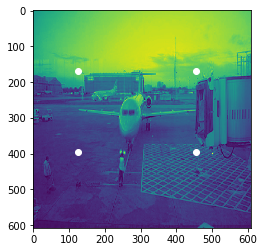

In [52]:
plt.imshow(i[:,:,0])
plt.scatter((l[0,1]-l[0,3]/2)*IMG_OUT_W, (l[0,0]-l[0,2]/2)*IMG_OUT_H, color='w')
plt.scatter((l[0,1]-l[0,3]/2)*IMG_OUT_W, (l[0,0]+l[0,2]/2)*IMG_OUT_H, color='w')
plt.scatter((l[0,1]+l[0,3]/2)*IMG_OUT_W, (l[0,0]-l[0,2]/2)*IMG_OUT_H, color='w')
plt.scatter((l[0,1]+l[0,3]/2)*IMG_OUT_W, (l[0,0]+l[0,2]/2)*IMG_OUT_H, color='w')
plt.show()

## Write data to TFRecord format

In [56]:
# conversion functions (data to feature data types)
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def write_example_to_TFRecord(filename, writer):
    # get processed data
    img, target = get_processed_data(filename)
    
    # create example from this data
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'img': _bytes_feature(img.tostring()),
                'target': _bytes_feature(target.tostring())
            }
        )
    )

    writer.write(example.SerializeToString())


def write_data_to_TFRecord():        
    # read filenames
    filenames = sorted(os.listdir(DIR_INPUT))
    filenames = [filename[:-4] for filename in filenames]  # trim extension    
    
    # write data into multiple TFRecord files
    idx_tfrecord, idx_data = 0, 0
    if not os.path.exists(DIR_TFRECORDS):
        os.makedirs(DIR_TFRECORDS)
    
    while idx_data < len(filenames):
        # new TFRecord file
        filename_tfrecord = os.path.join(DIR_TFRECORDS, str(idx_tfrecord) + '.tfrecords')
        with tf.python_io.TFRecordWriter(filename_tfrecord) as writer:
            # write examples into this file until limit is reached
            idx_example = 0
            while idx_data < len(filenames) and idx_example < NUM_EXAMPLES_PER_TFRECORD:
                filename = filenames[idx_data]
                write_example_to_TFRecord(filename, writer)
                idx_data += 1
                idx_example += 1
            idx_tfrecord += 1

In [57]:
write_data_to_TFRecord()